In [1]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt

In [2]:
# Parametros del sistema
M = 10 # [kg]
m = 80 # [kg]
c = 0.1 # [N s/m]
g = 9.81 # [m/s^2]
J = 100 # [kg m^2 /s^2]
l = 1 # [m]
Y = 0.01 # [N m s]

In [3]:
Mt = M + m
Jt = J + m*(l**2)
mu = Mt*Jt - (m**2)*(l**2)

A = np.matrix([[0, 0, 1, 0],
               [0, 0, 0, 1],
               [0, (m**2)*(l**2)*g/mu, -c*Jt/mu, -Y*Jt*l*m/mu],
               [0, Mt*m*g*l/mu, -c*l*m/mu, -Y*Mt/mu]])

B = np.array([[0],
               [0],
               [Jt/mu],
               [l*(m/mu)]])

C = np.array([[1, 0, 0, 0]])

D = 0

cart_ss = ctrl.StateSpace(A, B, C, 0)
cart_ss

StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  6.40653061e+00, -1.83673469e-03,
        -1.46938776e-02],
       [ 0.00000000e+00,  7.20734694e+00, -8.16326531e-04,
        -9.18367347e-05]]), array([[0.        ],
       [0.        ],
       [0.01836735],
       [0.00816327]]), array([[1., 0., 0., 0.]]), array([[0.]]))

In [4]:
eigenvalues = np.linalg.eigvals(A)
eigenvalues

array([ 0.00000000e+00,  2.68424392e+00, -2.68506138e+00, -1.11110915e-03])

/home/belphegor/.local/lib/python3.11/site-packages/control/timeresp.py:1197: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
/home/belphegor/.local/lib/python3.11/site-packages/control/timeresp.py:1197: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]


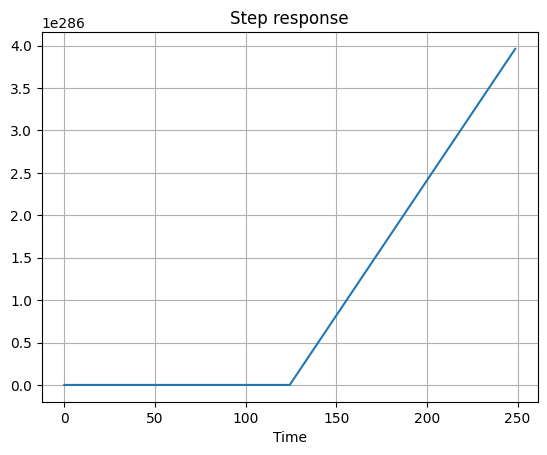

In [6]:
# Respuesta ante una entrada de tipo 'step'
t, yout, x = ctrl.step_response(cart_ss, return_x = True)

plt.figure()
plt.plot(t, yout)
plt.title('Step response')
plt.xlabel('Time')
plt.grid('minor')
plt.show()

In [7]:
# Eigenvalores del sistema en lazo cerrado
print(np.linalg.eigvals(A - B*C))

[ 2.68290361e+00+0.j         -2.68370230e+00+0.j
 -5.64943070e-04+0.10546067j -5.64943070e-04-0.10546067j]


In [8]:
cart_ss_cl = ctrl.feedback(sys1=cart_ss, sys2=1, sign=-1)
cart_ss_cl

StateSpace(array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [-1.83673469e-02,  6.40653061e+00, -1.83673469e-03,
        -1.46938776e-02],
       [-8.16326531e-03,  7.20734694e+00, -8.16326531e-04,
        -9.18367347e-05]]), array([[0.        ],
       [0.        ],
       [0.01836735],
       [0.00816327]]), array([[1., 0., 0., 0.]]), array([[0.]]))

/home/belphegor/.local/lib/python3.11/site-packages/control/timeresp.py:1199: RuntimeWarning: invalid value encountered in matmul
  yout = C @ xout + D @ U


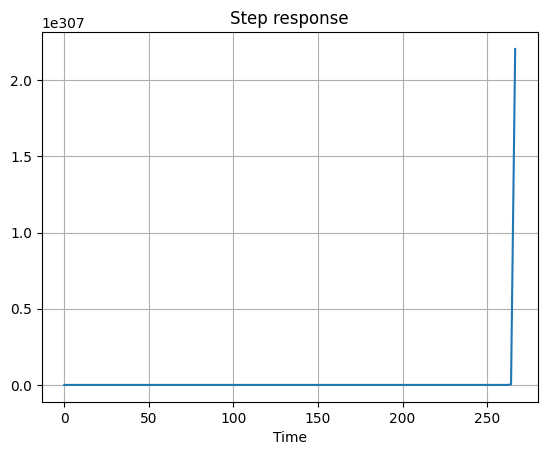

In [9]:
# Respuesta ante una entrada de tipo 'step' para el sistema en lazo cerrado
t_cl, yout_cl, x_cl = ctrl.step_response(cart_ss_cl, return_x = True)

plt.figure()
plt.plot(t_cl, yout_cl)
plt.title('Step response')
plt.xlabel('Time')
plt.grid('minor')
plt.show()


In [10]:
def get_kr(sys, K):
    """
     This function finds the scale factor kr which will
     eliminate the steady-state error to a step reference.
     
                               /---------\
           ref       +     u  | .       |
          ---> kr --->() ---->| X=Ax+Bu |--> y=Cx ---> y
                     -|       \---------/
                      |             | 
                      |<---- K <----|

    Parameters
    ----------
    sys : StateSpace of a linear system
        SISO continuous-time using ctrl.ss().
    K : Vector of dimension [1xn]
        Feedback vector K.

    Returns
    -------
    Array of float64
        Scale factor kr.

    """
    s = sys.A.shape[0]
    Z = np.hstack((np.zeros((1,s)), [[1]]))
    N = np.dot(np.linalg.inv(np.vstack((np.hstack((sys.A, sys.B)), np.hstack((sys.C, sys.D))))), Z.T)
    Nx = N[0:s]
    Nu = N[s]
    return Nu + np.dot(K,Nx)

In [11]:
# Eigenvalores deseados
eig_d = np.array([-1 + 2j, -1 - 2j, -0.35 + 0.35j, -0.35 - 0.35j])

K = ctrl.place(A, B, eig_d)
print('K:= ', K)

array([[ -15.29689093, 1730.60901706,  -49.90156883,  442.79227986]])

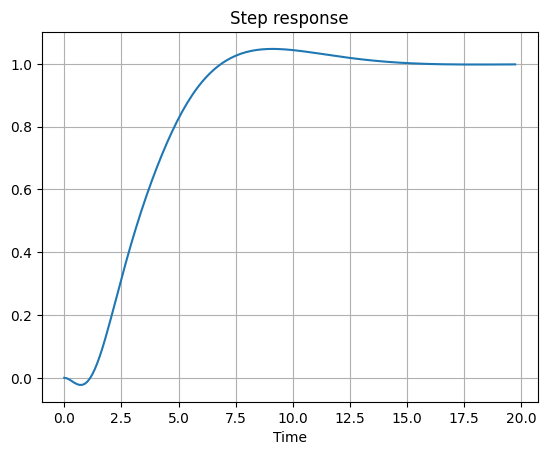

In [12]:
kr = get_kr(cart_ss, K)
print('k_r:= ', kr)

Acl = A - B*K
Bcl = kr*B

# Respuesta ante una entrada de tipo 'step' para el sistema en lazo cerrado
cart_ss_cl_K = ctrl.ss(Acl, Bcl, C, 0)
t_cl, yout_cl, x_cl = ctrl.step_response(cart_ss_cl_K, return_x = True)

plt.figure()
plt.plot(t_cl, yout_cl)
plt.title('Step response')
plt.xlabel('Time')
plt.grid('minor')
plt.show()


In [13]:
ctrl.step_info(cart_ss_cl_K)

{'RiseTime': 3.8127220695680695,
 'SettlingTime': 12.447416168295755,
 'SettlingMin': 0.901325871653124,
 'SettlingMax': 1.047642165920905,
 'Overshoot': 4.764216592090475,
 'Undershoot': 2.262478704626095,
 'Peak': 1.047642165920905,
 'PeakTime': 9.083249636323929,
 'SteadyStateValue': 1.0000000000000002}